# Machine Learning Models and (Alternative) Ensemble Method
---

1. Split X-Features and y-labels
2. Stratified k-fold Validation for range of models:
    1. SVM
    2. DT
    3. AdaBoost
    4. RF
    5. ExtraTrees
    6. GradientBoosting
    7. MLP
    8. KNN
    9. LogReg
    10. LDA
    11. XGB
3. Choosing best models and training them
4. __Better__ Ensemble Method:
5. Evaluate Ensemble on TEST data

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable GPU
#from tqdm import tqdm # progress bar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# processing / validation
from imblearn.over_sampling import ADASYN # over-sampling
from sklearn.model_selection import cross_val_score, StratifiedKFold

# models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# constant seed for reproducibility
SEED = 111
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
#tf.random.set_seed(SEED)

# cpu worker
WORKERS = 4

## 1- X/y Split:

In [2]:
df = pd.read_csv("UFC_TRAIN.csv")
X = df.drop(["date","Winner","B_fighter","R_fighter"], axis=1).values
y = df["Winner"].values

# over-sampling
over_sampler = ADASYN()
X, y = over_sampler.fit_sample(X, y)

pd.Series(y).value_counts()

0    2985
1    2910
dtype: int64

## 2- Stratified k-Fold-Validation with a Range of models

    Mean_Accuracy  CrossValerrors         Algorithm
4        0.801455        0.116798        ExtraTrees
3        0.767058        0.162530                RF
5        0.751968        0.172484  GradientBoosting
10       0.749935        0.174582               XGB
1        0.693910        0.121499                DT
2        0.693067        0.128241          AdaBoost
7        0.673648        0.034880               KNN
9        0.621205        0.025117               LDA
8        0.616116        0.032592            LogReg
6        0.591182        0.036810               MLP
0        0.586254        0.021493               SVM


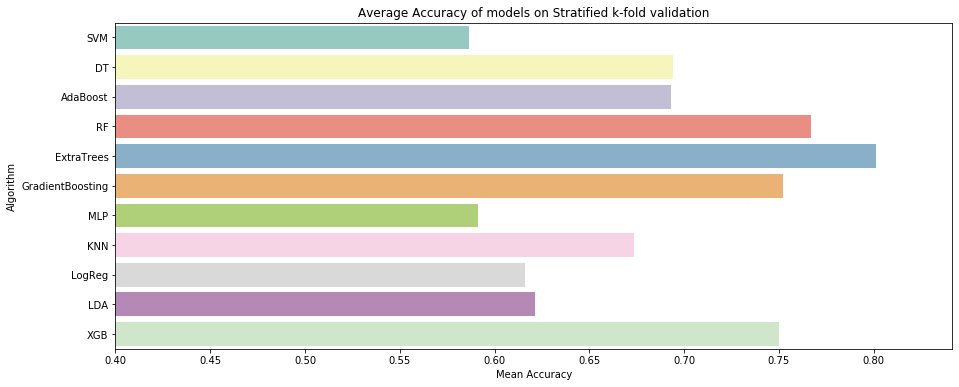

In [3]:
classifiers = [
    SVC(random_state=SEED),
    DecisionTreeClassifier(random_state=SEED),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=SEED),random_state=SEED,learning_rate=0.1),
    RandomForestClassifier(random_state=SEED),
    ExtraTreesClassifier(random_state=SEED),
    GradientBoostingClassifier(random_state=SEED),
    MLPClassifier(random_state=SEED),
    KNeighborsClassifier(),
    LogisticRegression(random_state = SEED),
    LinearDiscriminantAnalysis()
]
classifiers.append(XGBClassifier(n_estimators=200)) # we can append models 

kfold = StratifiedKFold( n_splits=10 ) # k = 10 stratified folds
cv_results = [] # for EACH model holds k, i.e:10, cv-accuracy results (shape: no. of models x K)
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X=X, y = y, scoring = "accuracy", cv = kfold, n_jobs=WORKERS))

# mean accuracy and std of each model (shape: no. of models)
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"Mean_Accuracy":cv_means,
                       "CrossValerrors": cv_std,
                       "Algorithm":
                       [
                           "SVM",
                           "DT",
                           "AdaBoost",
                           "RF",
                           "ExtraTrees",
                           "GradientBoosting",
                           "MLP",
                           "KNN",
                           "LogReg",
                           "LDA",
                           "XGB"
                       ]
                      }
                     )
print(cv_res.sort_values("Mean_Accuracy", ascending=False))
plt.figure(figsize=(15,6))
g = sns.barplot(x="Mean_Accuracy",y="Algorithm",data = cv_res, palette="Set3",orient = "h")
g.set(xlim=(0.4))
g.set_xlabel("Mean Accuracy")
g = g.set_title("Average Accuracy of models on Stratified k-fold validation")


## 3- Model Selection:
__LDA, GradientBoosting and LogReg are chosen to be in Ensemble model__

In [4]:
ldaClf = LinearDiscriminantAnalysis()
ldaClf = ldaClf.fit(X,y)

gboostClf = GradientBoostingClassifier(random_state=SEED)
gboostClf = gboostClf.fit(X,y)

lrClf = LogisticRegression(random_state = SEED,n_jobs=WORKERS)
lrClf = lrClf.fit(X,y)

#exTreeClf = ExtraTreesClassifier(random_state=SEED)
#exTreeClf = exTreeClf.fit(X,y)

#rfClf = RandomForestClassifier(random_state=SEED)
#rfClf = rfClf.fit(X,y)

# the following is redundant as k-fold-val has been performed previously
#ldaScore = cross_val_score(ldaClf, X=X, y = y, scoring = "accuracy", cv = kfold, n_jobs=WORKERS).mean()
#print(f"LDA k-fold-val-avg-Accuracy: {ldaScore}")
#gboostScore = cross_val_score(gboostClf, X=X, y = y, scoring = "accuracy", cv = kfold, n_jobs=WORKERS).mean()
#print(f"GBOOST k-fold-val-avg-Accuracy: {gboostScore}")
#lraScore = cross_val_score(lrClf, X=X, y = y, scoring = "accuracy", cv = kfold, n_jobs=WORKERS).mean()
#print(f"LogReg k-fold-val-avg-Accuracy: {lraScore}")


## 4- Ensemble Method

In [8]:
ensClf = VotingClassifier(estimators=
                          [
                              ('ldaClf', ldaClf),
                              ('gboostClf', gboostClf),
                              ('lrClf', lrClf),
                              #('exTreeClf', exTreeClf),
                              #('rfClf', rfClf)
                          ],
                          voting='soft', n_jobs=WORKERS)
ensClf = ensClf.fit(X, y)
print(f"{len([e[0] for e in ensClf.estimators])} Models in Ensemble: {[e[0] for e in ensClf.estimators]}")

3 Models in Ensemble: ['ldaClf', 'gboostClf', 'lrClf']


## 5- Performance Evaluation on TEST (unseen data):

In [9]:
TEST = pd.read_csv("UFC_TEST.csv")
X_TEST = TEST.drop(["date","B_fighter","R_fighter","Winner"],axis=1).values
y_TEST = TEST["Winner"].values
target_names = ['class 0', 'class 1']
ensPreds_TEST = ensClf.predict(X_TEST)
print("Ensemble TEST Performance on UNBALANCED(!):\n------------------\n",classification_report(y_TEST, ensPreds_TEST , target_names=target_names))
print("AUC: ",roc_auc_score(y_TEST, ensPreds_TEST))

Ensemble TEST Performance on UNBALANCED(!):
------------------
               precision    recall  f1-score   support

     class 0       0.75      0.72      0.74       157
     class 1       0.46      0.51      0.48        75

    accuracy                           0.65       232
   macro avg       0.61      0.61      0.61       232
weighted avg       0.66      0.65      0.65       232

AUC:  0.6132059447983016
